In [1]:
import cv2
import PIL
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Video

In [2]:
if "google.colab" in str(get_ipython()):
    from google.colab.patches import cv2_imshow

    imshow = cv2_imshow
else:
    def imshow(img):
        vmin = 0
        vmax = img.max()
        if vmax > 1:
            vmax = 255
        if vmax > 1:
            img = img.astype(np.uint8)
        img = np.array(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        plt.axis('off')
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
        else:
            plt.imshow(img, vmin=vmin, vmax=vmax)
        plt.show()

Single frame extraction to detect objects

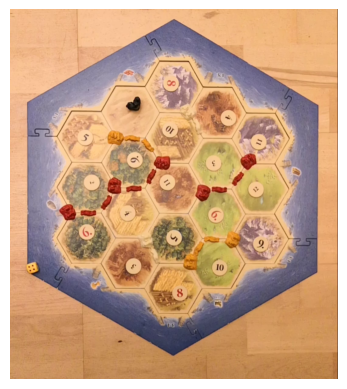

Frame extracted and saved as 'frame_100.jpg'


In [3]:
video_path = "catan2.mp4"
cap = cv2.VideoCapture(video_path)

frame_number = 0 # 100
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

# Read the frame
ret, frame = cap.read()

if ret:
    imshow(frame)
    cv2.imwrite("frame_100.jpg", frame)
    print("Frame extracted and saved as 'frame_100.jpg'")
else:
    print("Failed to extract frame.")

# Release the video capture object
cap.release()

### Settlement detection

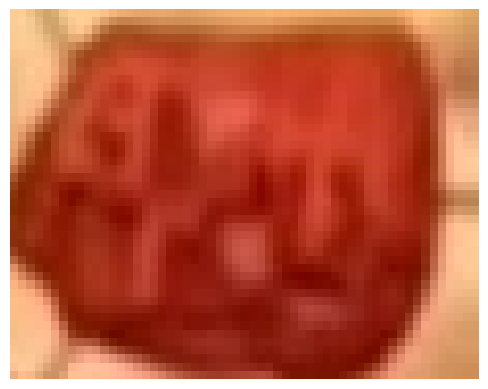

In [4]:
# Settlment template extracted from frame_100 using 'Paint' operations:)
settlement_template = cv2.imread("settlement_template.jpg", 1)
imshow(settlement_template)

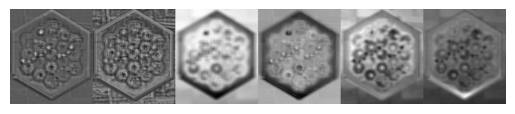

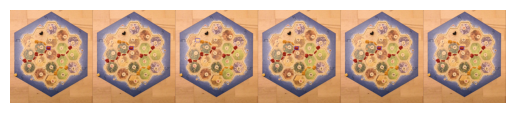

In [5]:
methods = [
    cv2.TM_CCOEFF,
    cv2.TM_CCOEFF_NORMED,
    cv2.TM_CCORR,
    cv2.TM_CCORR_NORMED,
    cv2.TM_SQDIFF,
    cv2.TM_SQDIFF_NORMED,
]

_, w, h = settlement_template.shape[::-1]

results_rgb = []
results_prob = []
for method in methods:
    _frame = frame.copy()
    # Apply template Matching
    res = cv2.matchTemplate(_frame, settlement_template, method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(_frame, top_left, bottom_right, (255, 0, 0), 2)

    results_rgb.append(_frame)
    results_prob.append((res - res.min()) * 255 / (res.max() - res.min()))

imshow(np.concatenate(results_prob, 1))
imshow(np.concatenate(results_rgb, 1))

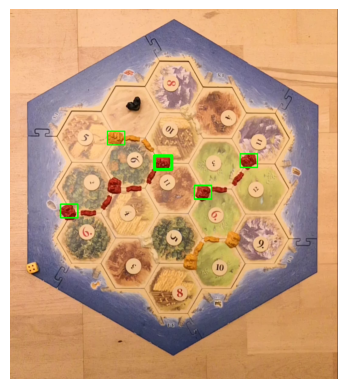

In [6]:
_frame = frame.copy()

res = cv2.matchTemplate(_frame, settlement_template, cv2.TM_CCORR_NORMED)
loc = np.where(res >= 0.95)
for pt in zip(*loc[::-1]):
    cv2.rectangle(_frame, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)

imshow(_frame)

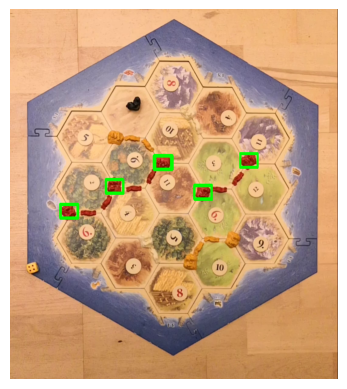

In [7]:
_frame = frame.copy()

res = cv2.matchTemplate(_frame, settlement_template, cv2.TM_SQDIFF_NORMED)
loc = np.where(res <= 0.12)
for pt in zip(*loc[::-1]):
    cv2.rectangle(_frame, pt, (pt[0] + w, pt[1] + h), (0, 255, 0), 2)

imshow(_frame)

### Number tokens detection

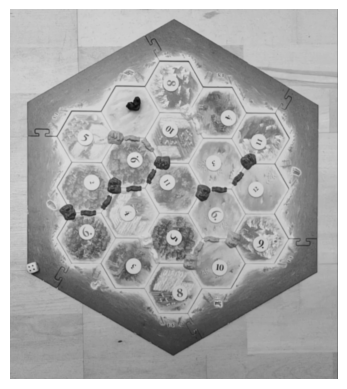

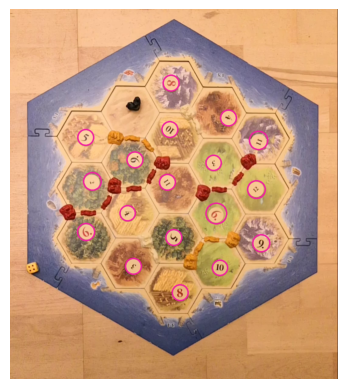

Number tokens count: 18


In [8]:
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(frame_gray, (5, 5), 0)
imshow(blurred)
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, 1.2, 40, 
                           param1=10, param2=45, minRadius=20, maxRadius=35)

img_result = frame.copy()
if circles is not None:
    circles = np.round(circles[0,]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(img_result, (x, y), r, (160, 32, 240), 3)  # Draw circle
    
imshow(img_result)
print("Number tokens count:", len(circles))

### Dice tracking

In [9]:
catan = cv2.VideoCapture("catan2.mp4")
if catan.isOpened():
    print("Video loaded")

catan_width = int(catan.get(3))
catan_height = int(catan.get(4))

print(catan_height, catan_width)

catan_fps = catan.get(cv2.CAP_PROP_FPS)
print(catan_fps)

Video loaded
1220 1080
29.00105671137738


In [10]:
catan.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = catan.read()
x, y, w, h = 60, 835, 50, 50 # simply hardcoded the values
track_window = (x, y, w, h)
roi = frame[y : y + h, x : x + w]

hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(
    hsv_roi, np.array((0.0, 60.0, 32.0)), np.array((180.0, 255.0, 255.0))
)
roi_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0, 180])
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)

In [11]:
dice_track = cv2.VideoWriter(
    "./dice_track_meanShift.avi",
    cv2.VideoWriter_fourcc(*"DIVX"),
    catan_fps,
    (catan_width, catan_height),
)

catan.set(cv2.CAP_PROP_POS_FRAMES, 0)
while catan.isOpened():
    ret, frame = catan.read()

    if ret:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv], [0], roi_hist, [0, 180], 1)
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)
        x, y, w, h = track_window
        dice_track.write(cv2.rectangle(frame, (x, y), (x + w, y + h), 255, 2))
    else:
        break

dice_track.release()

In [12]:
!ffmpeg -hide_banner -loglevel error -i dice_track_meanShift.avi -y dice_track_meanShift.mp4

In [13]:
Video.from_file("./dice_track_meanShift.mp4")

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')